In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time


Enter the starting floor: 0
Enter the desired floor: 4
Moving lift up
Moving lift up


<IPython.core.display.Javascript object>

Number of humans: 1
Image saved as photo_20230713-161122.jpg


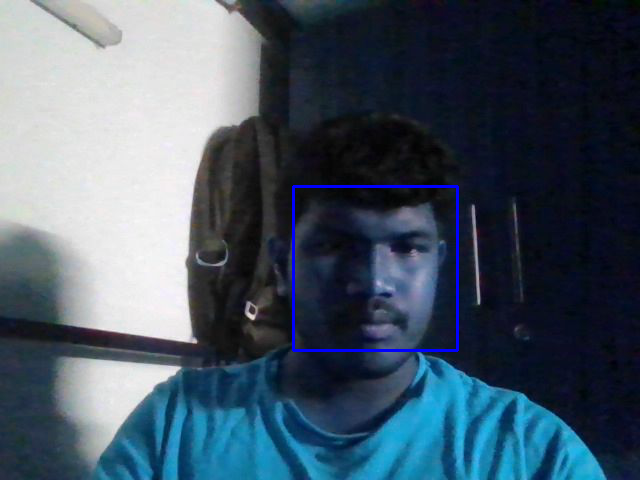

Opening doors
Stopping at floor 1
Closing doors
Moving lift up


<IPython.core.display.Javascript object>

Number of humans: 1
Image saved as photo_20230713-161131.jpg


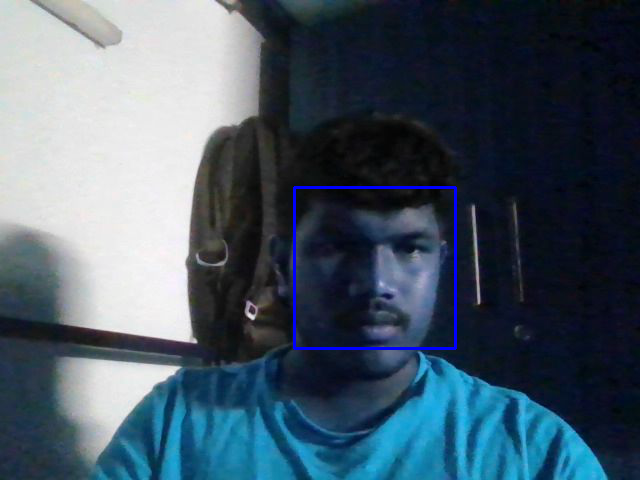

Opening doors
Stopping at floor 2
Closing doors
Moving lift up


<IPython.core.display.Javascript object>

Number of humans: 1
Image saved as photo_20230713-161139.jpg


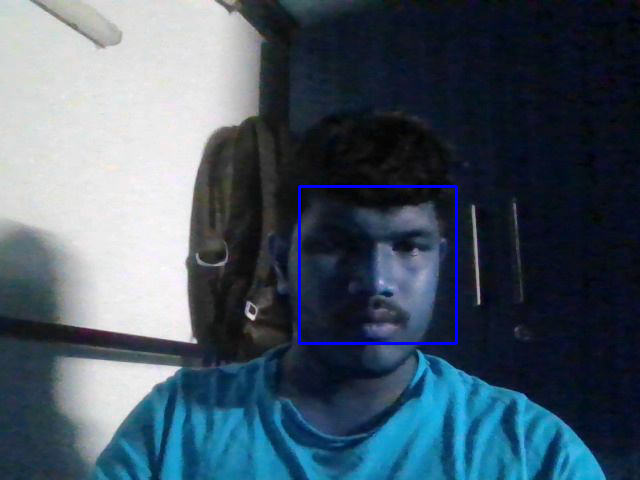

Opening doors
Stopping at floor 3
Closing doors
Moving lift up


<IPython.core.display.Javascript object>

Number of humans: 1
Image saved as photo_20230713-161147.jpg


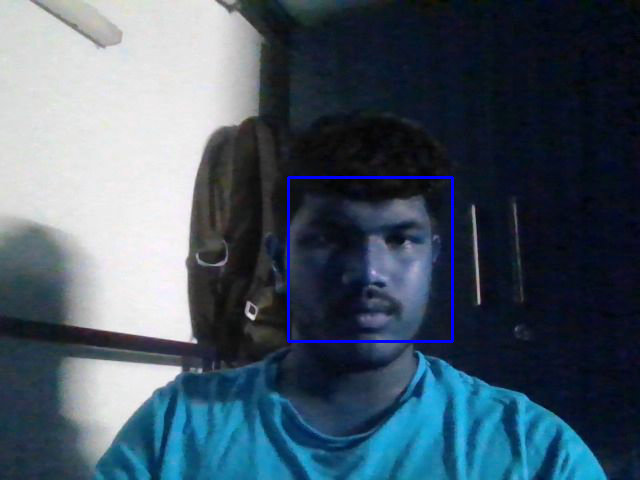

Opening doors
Stopping at floor 4
Closing doors
Opening doors
Stopping at floor 4
Closing doors
Elevator is now idle


In [ ]:
import cv2
import numpy as np
from IPython.display import display, Javascript
from google.colab.patches import cv2_imshow
import base64
import io
import PIL.Image
import time

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
human_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_fullbody.xml')

def bbox_to_bytes(bbox_array):
    """
    Convert a NumPy array (image) to bytes format for displaying in Jupyter Notebook.
    """
    _, encoded_image = cv2.imencode('.png', bbox_array)
    return encoded_image.tobytes()

def js_to_image(js_reply):
    """
    Convert base64 image data received from JavaScript to a PIL Image object.
    """
    image_bytes = base64.b64decode(js_reply.split(',')[1])
    image = PIL.Image.open(io.BytesIO(image_bytes))
    return image

def capture_photo(quality=0.8):
    # Delay before capturing the image
    time.sleep(2)

    js = Javascript('''
        async function capturePhoto(quality) {
            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            await new Promise((resolve) => setTimeout(resolve, 2000));  // Wait for 2 seconds

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            document.body.removeChild(video);

            // Return the image data
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)

    # Capture photo
    data = eval_js('capturePhoto({})'.format(quality))

    # Get OpenCV format image
    img = js_to_image(data)
    # Convert image to grayscale
    gray = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)

    # Detect faces using Haar Cascade
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    # Detect humans using Haar Cascade
    humans = human_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    # Count the number of humans
    human_count = len(faces) + len(humans)
    print('Number of humans: {}'.format(human_count))

    # Draw face and human bounding boxes on the image
    for (x, y, w, h) in faces:
        img = cv2.rectangle(np.array(img), (x, y), (x+w, y+h), (255, 0, 0), 2)

    for (x, y, w, h) in humans:
        img = cv2.rectangle(np.array(img), (x, y), (x+w, y+h), (0, 255, 0), 2)

    # Save the image
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    filename = 'photo_{}.jpg'.format(timestamp)
    cv2.imwrite(filename, np.array(img))
    print('Image saved as {}'.format(filename))

    # Display the image
    cv2_imshow(np.array(img))


class Elevator:
    def __init__(self, num_floors):
        self.num_floors = num_floors
        self.current_floor = 1
        self.direction = 0
        self.requested_floors = []
        self.doors_open = False

    def open_doors(self):
        print("Opening doors")
        self.doors_open = True

    def close_doors(self):
        print("Closing doors")
        self.doors_open = False

    def move_lift(self):
        if self.direction == 1:
            print("Moving lift up")
            self.current_floor += 1
        elif self.direction == -1:
            print("Moving lift down")
            self.current_floor -= 1

    def process_floor_request(self, floor):
        if floor == self.current_floor:
            self.open_doors()
            print("Stopping at floor", floor)
            self.close_doors()
            return

        if floor > self.current_floor:
            self.direction = 1
        else:
            self.direction = -1

        while self.current_floor != floor:
            self.move_lift()
            if self.detect_human():
                self.open_doors()
                print("Stopping at floor", self.current_floor)
                self.close_doors()
            else:
                print("No human detected at floor", self.current_floor)
                return

        self.open_doors()
        print("Stopping at floor", floor)
        self.close_doors()

    def add_floor_request(self, floor):
        if floor not in self.requested_floors:
            self.requested_floors.append(floor)
            if self.direction == 0:
                if floor > self.current_floor:
                    self.direction = 1
                    print("Moving lift up")
                else:
                    self.direction = -1
                    print("Moving lift down")

    def process_floor_requests(self):
        if len(self.requested_floors) == 0:
            self.direction = 0
            return

        while len(self.requested_floors) > 0:
            floor = self.requested_floors.pop(0)
            self.process_floor_request(floor)

        self.direction = 0
        print("Elevator is now idle")

    def detect_human(self):
        # Perform random human detection logic
        # Replace this with your own human detection logic using camera input
        # For this example, simulate human detection by capturing a photo and counting the number of humans
        capture_photo()
        time.sleep(2)  # Wait for 2 seconds to capture the photo and process it
        human_count = 3  # Assuming 3 humans are detected in the photo
        return human_count > 0


# Example usage
num_floors = 10
elevator = Elevator(num_floors)

# Get the starting floor
start_floor = int(input("Enter the starting floor: "))
elevator.current_floor = start_floor

# Simulate a person approaching the elevator and pressing the button for the desired floor
person_floor = int(input("Enter the desired floor: "))
elevator.add_floor_request(person_floor)

# Simulate processing floor requests
elevator.process_floor_requests()
